In [1]:
# General imports

from argparse import Namespace
import time
import sys
import pprint
import numpy as np
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt
import cv2
import random
import glob
from tqdm import tqdm
import PIL
import PIL.Image
%matplotlib inline

# Importing pSp related

pSp_root = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), 'pixel2style2pixel'))
sys.path.insert(0, pSp_root)

from pixel2style2pixel.datasets import augmentations
from pixel2style2pixel.utils.common import tensor2im, log_input_image
from pixel2style2pixel.models.psp import pSp
from pixel2style2pixel.models.stylegan2.model import Generator # Importing stylegan2 model from pSp repo, same thing eventually

In [2]:
# Define the pSp encoder - StyleGANv2 decoder and load pretrained weights

device = 'cuda'

ENDECODER_ARGS = {
    "pSp_model_path": "pretrained_models/psp_ffhq_encode.pt",
    "StyleGANv2_model_path": "pretrained_models/stylegan2-ffhq-config-f.pt",
    "transform": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}

ckpt = torch.load(ENDECODER_ARGS['pSp_model_path'], map_location='cpu')
pSp_opts = ckpt['opts']

pSp_opts['checkpoint_path'] = ENDECODER_ARGS['pSp_model_path']
pSp_opts['stylegan_weights'] = ENDECODER_ARGS['StyleGANv2_model_path']
pSp_opts['learn_in_w'] = False
pSp_opts['output_size'] = 1024

pSp_net = pSp(Namespace(**pSp_opts))
pSp_net.eval()
pSp_net.cuda();

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt


In [3]:
# Define the function to normalize images and convert to numpy

# This normalization block is taken from the original torch repository:
# https://github.com/pytorch/vision/blob/89d2b38cbc3254ed7ed7b43393e4635979ac12eb/torchvision/utils.py

def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

def normalize_image_and_convert_to_numpy(image):
    norm_range(image, (-1, 1))
    return image.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()

pool_logit = torch.nn.AdaptiveAvgPool2d((256, 256))

In [4]:
# Define a function that generates a random image

def generate_random_image(downscale=False):
    z = torch.randn(1, 512, device=device) # args.sample, args.latent
    gen_img, latent = pSp_net.decoder(
        [z], truncation=1, truncation_latent=None, return_latents=True # args.truncation
    )
    if downscale:
        gen_img = pool_logit(gen_img)
    return Image.fromarray(normalize_image_and_convert_to_numpy(gen_img[0])), latent # returns tensor

# Define a function that generates an image for the given code

def generate_image_given_code(code, downscale=False):
    with torch.no_grad():
        gen_img, latent = pSp_net.decoder(
            [code], truncation=1, truncation_latent=None, return_latents=True, input_is_latent=True, randomize_noise=False # args.truncation
        )
        if downscale:
            gen_img = pool_logit(gen_img)
        return Image.fromarray(normalize_image_and_convert_to_numpy(gen_img[0])), latent # returns tensor

# Define a function that encodes a given image and returns the code alongside its decoding (its 'fake' recreation)

def encode_given_image_return_code_and_recreation(image, downscale=False):
    img_transforms = ENDECODER_ARGS['transform']
    transformed_image = img_transforms(image)
    latent = pSp_net.encoder(transformed_image.unsqueeze(0).to(device))
    latent = latent + pSp_net.latent_avg.repeat(latent.shape[0], 1)

    image, latent = generate_image_given_code(latent, downscale)
    return image, latent

# Define a function that generates an image or encodes a given image and returns image-code pair

def generate_an_image_code_pair(image=None, downscale=False):
    if image is None:
        return generate_random_image(downscale)
    else:
        return encode_given_image_return_code_and_recreation(image, downscale)
    
# Define a function to load an image from its path, optionally aligns it and returns loadedimage-generatedimage-code

def load_image_and_encode(path):
    image = PIL.Image.open(path)
    gen_image, gen_code = encode_given_image_return_code_and_recreation(image)
    return image, gen_image, gen_code

In [5]:
# Define a function to neutralize latent code

def neutralize_latent_code(code, neutral_dir, neutral_strength=20):
    code, neutral_dir = code.detach().cpu().flatten(), neutral_dir.detach().cpu().flatten()
    distance = np.dot(neutral_dir, code) / np.linalg.norm(neutral_dir)
    direction = neutral_dir / np.linalg.norm(neutral_dir)
    neutral_code = code - distance * direction
    neutral_code = neutral_code + neutral_strength * direction
    return neutral_code.reshape(18, 512).unsqueeze(0).cuda()

# Define a function to transfer emotion from code A to B

def transfer_emotion_on_code(code_A, code_B, neutral_dir, neutral_strength):
    code_A_neu = neutralize_latent_code(code_A, neutral_dir, neutral_strength)
    code_B_neu = neutralize_latent_code(code_B, neutral_dir, neutral_strength)

    return (code_A - code_A_neu) + code_B_neu

# Define a function to transfer emotion from image A to B

def transfer_emotion_on_image(image_A, image_B, neutral_dir, neutral_strength):
    code_A = encode_given_image_return_code_and_recreation(image_A)[1]
    code_B = encode_given_image_return_code_and_recreation(image_B)[1]
    
    image_A_neu, code_A_neu = generate_image_given_code(neutralize_latent_code(code_A, neutral_dir, neutral_strength))
    image_B_neu, code_B_neu = generate_image_given_code(neutralize_latent_code(code_B, neutral_dir, neutral_strength))
    
    image_A_neu_inv, code_A_neu_inv = encode_given_image_return_code_and_recreation(image_A_neu) 
    image_B_neu_inv, code_B_neu_inv = encode_given_image_return_code_and_recreation(image_B_neu)

    transfer_code = (code_A - code_A_neu_inv) + code_B_neu_inv

    return generate_image_given_code(transfer_code)[0]


# Define a function to transfer emotion from image A to B that utilizes pre-computed delta

def transfer_emotion_on_image_using_delta(delta, code_B_neu_inv):
    return generate_image_given_code(delta + code_B_neu_inv)[0]

In [6]:
# Load up directions

anger_dir = torch.from_numpy(np.load('main_directions/0.npy').astype(np.float32)).to(device)
contempt_dir = torch.from_numpy(np.load('main_directions/1.npy').astype(np.float32)).to(device)
disgust_dir = torch.from_numpy(np.load('main_directions/2.npy').astype(np.float32)).to(device)
fear_dir = torch.from_numpy(np.load('main_directions/3.npy').astype(np.float32)).to(device)
happiness_dir = torch.from_numpy(np.load('main_directions/4.npy').astype(np.float32)).to(device)
neutral_dir = torch.from_numpy(np.load('main_directions/5.npy').astype(np.float32)).to(device)
sadness_dir = torch.from_numpy(np.load('main_directions/6.npy').astype(np.float32)).to(device)
surprise_dir = torch.from_numpy(np.load('main_directions/7.npy').astype(np.float32)).to(device)

In [7]:
def transfer_emotion_on_image(image_A, image_B, neutral_dir, neutral_strength):
    code_A = encode_given_image_return_code_and_recreation(image_A)[1]
    code_B = encode_given_image_return_code_and_recreation(image_B)[1]
    
    image_A_neu, code_A_neu = generate_image_given_code(neutralize_latent_code(code_A, neutral_dir, neutral_strength))
    image_B_neu, code_B_neu = generate_image_given_code(neutralize_latent_code(code_B, neutral_dir, neutral_strength))
    
    image_A_neu_inv, code_A_neu_inv = encode_given_image_return_code_and_recreation(image_A_neu) 
    image_B_neu_inv, code_B_neu_inv = encode_given_image_return_code_and_recreation(image_B_neu)

    interpolations = []
    interpolation_ranges = np.arange(0, 1.125, 0.125)

    for a in interpolation_ranges:
        b = 1 - a
        transfer_code = (code_A - code_A_neu_inv) * a + (code_B - code_B_neu_inv) * b + code_B_neu_inv
        interpolations.append(generate_image_given_code(transfer_code)[0])

    return interpolations

In [9]:
for i in range(5):

    image_src_path, image_dst_path = random.sample(glob.glob('datasets/celeba_hq_aligned/*/*.jpg'), 2)

    im_src_og, im_src, _ = load_image_and_encode(image_src_path)
    im_dst_og, im_dst, _ = load_image_and_encode(image_dst_path)

    interpolations = transfer_emotion_on_image(im_src, im_dst, neutral_dir, 20)

    dir_path = os.path.join('inter_experiments', str(i))
    os.makedirs(dir_path, exist_ok=True)
    
    im_src.save(os.path.join(dir_path, 'src.jpg'))
    im_dst.save(os.path.join(dir_path, 'dst.jpg'))
    
    im_src_og.save(os.path.join(dir_path, 'src_og.jpg'))
    im_dst_og.save(os.path.join(dir_path, 'dst_og.jpg'))

    for j, interpolation in enumerate(interpolations):
        interpolation.save(os.path.join(dir_path, f'{j}.jpg'))

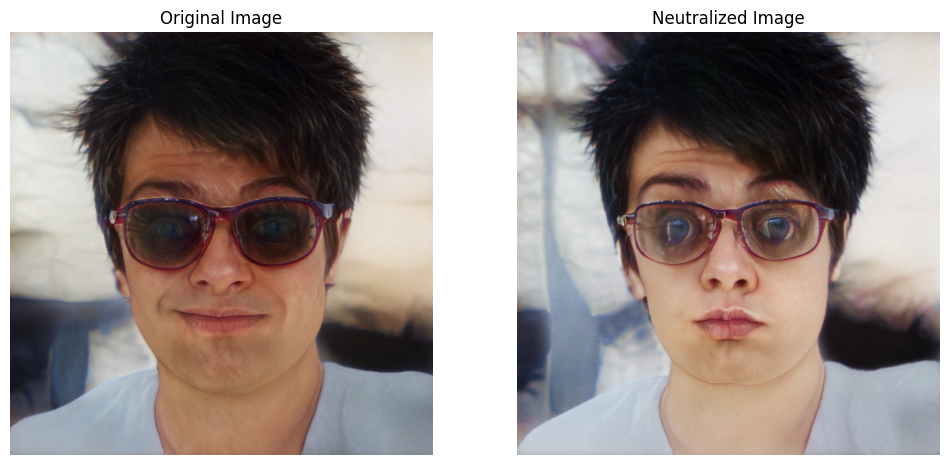

In [88]:
%matplotlib inline

image_src_path, image_dst_path = random.sample(glob.glob('datasets/celeba_hq_aligned/*/*.jpg'), 2)
_, ggen_img, code = load_image_and_encode(image_src_path)

neutralized_code = neutralize_latent_code(code, neutral_dir, 20)
generated_img = generate_image_given_code(neutralized_code)[0]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image
axs[0].imshow(ggen_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the second image
axs[1].imshow(generated_img)
axs[1].set_title('Neutralized Image')
axs[1].axis('off')

# Show the images
plt.show()

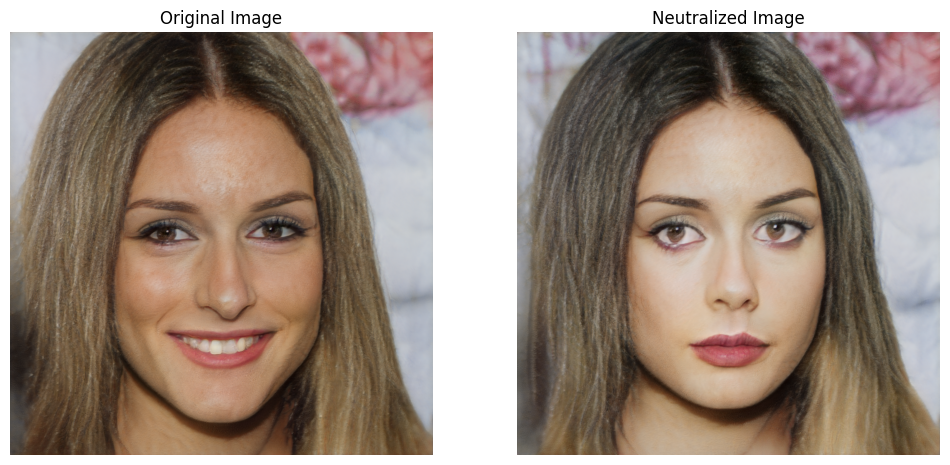

In [84]:
%matplotlib inline

image_src_path2, image_dst_path2 = random.sample(glob.glob('datasets/celeba_hq_aligned/*/*.jpg'), 2)
_, ggen_img2, code2 = load_image_and_encode(image_src_path2)

neutralized_code2 = neutralize_latent_code(code2, neutral_dir, 20)
generated_img2 = generate_image_given_code(neutralized_code2)[0]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image
axs[0].imshow(ggen_img2)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the second image
axs[1].imshow(generated_img2)
axs[1].set_title('Neutralized Image')
axs[1].axis('off')

# Show the images
plt.show()

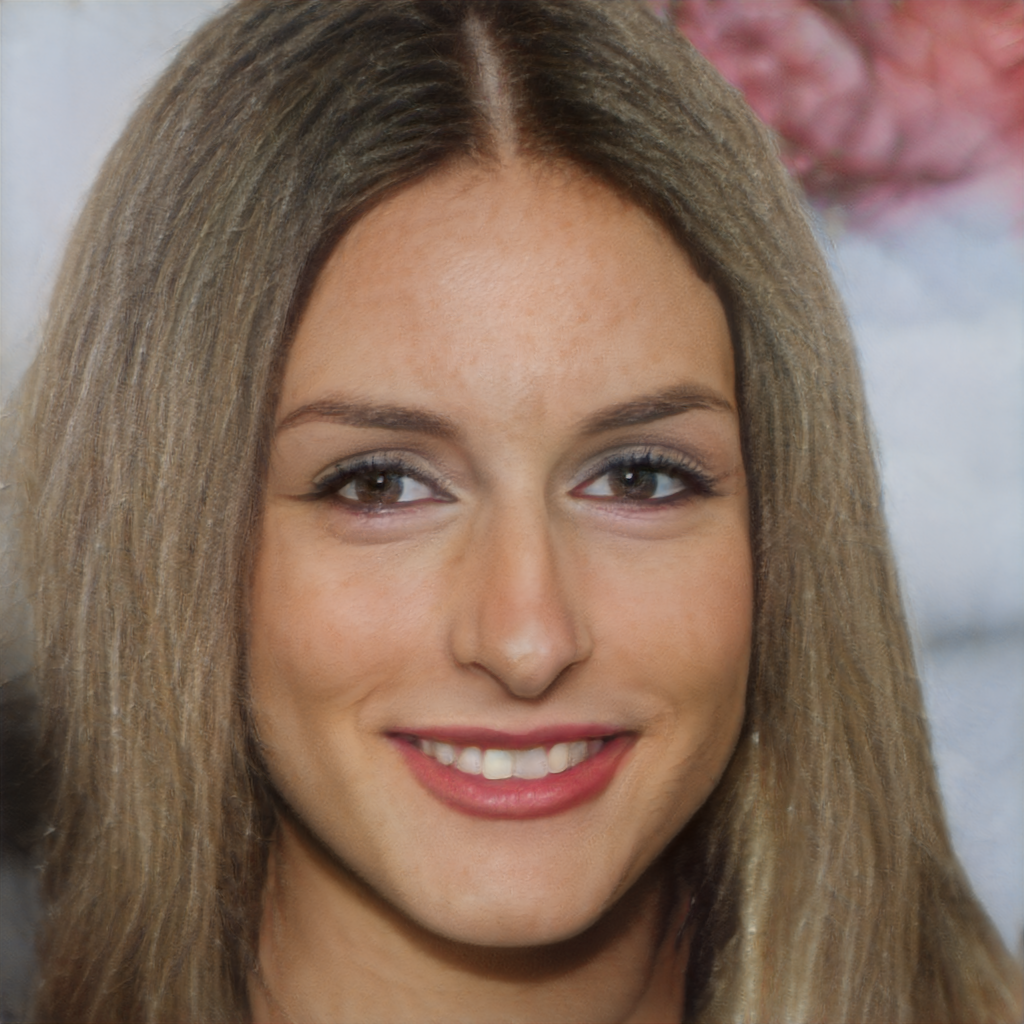

In [93]:
transfer_emotion_on_image(ggen_img, ggen_img2, neutral_dir, 20)